# Text Classification with BERT using Neural Modules - Inference


Import all required modules/functions/classes.

In [1]:
import nemo
import nemo.collections.nlp as nemo_nlp
from nemo.collections.nlp.data.datasets import BertTextClassificationDataset
from nemo.collections.nlp.nm.data_layers.text_classification_datalayer import BertTextClassificationDataLayer
from nemo.collections.nlp.nm.trainables import SequenceClassifier

from nemo.backends.pytorch.common import CrossEntropyLossNM
from nemo.utils.lr_policies import get_lr_policy
from nemo.collections.nlp.callbacks.text_classification_callback import eval_iter_callback, eval_epochs_done_callback

import os
import json
import math
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = -1

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
%matplotlib inline

import torch

from netapp_jupyter_utils import netappSnapshotCreate, netappGetSnapshots, netappRestoreSnapshot
from datetime import datetime

[NeMo W 2021-08-18 05:14:52 audio_preprocessing:56] Could not import torchaudio. Some features might not work.


# Inference Pipeline

The following steps set up and execute the inference pipeline using the real-world data set you will be working with.

## Recreate Model Architectures

Load up the model. If you watch your utilization tabs you will see GPU memory utilization increase somewhat.

## Load Trained Checkpoints

As you load the trained checkpoints, you will see GPU memory utilization increase further.

...

## Single Sentence Classification Inference

In [4]:
def classify_sentence(nf, tokenizer, bert, mlp, sentence):
    sentence = sentence.lower()
    tmp_file = "/tmp/tmp_sentence.tsv"
    with open(tmp_file, 'w+') as tmp_tsv:
        header = 'sentence\tlabel\n'
        line = sentence + '\t0\n'
        tmp_tsv.writelines([header, line])

    tmp_data = BertTextClassificationDataLayer(input_file=tmp_file,
                                               tokenizer=tokenizer,
                                               max_seq_length=128,
                                               batch_size=1)
    
    tmp_input, tmp_token_types, tmp_attn_mask, _ = tmp_data()
    tmp_embeddings = bert(input_ids=tmp_input,
                          token_type_ids=tmp_token_types,
                          attention_mask=tmp_attn_mask)
    tmp_logits = mlp(hidden_states=tmp_embeddings)
    tmp_logits_tensors = nf.infer(tensors=[tmp_logits, tmp_embeddings])
    tmp_probs = torch.nn.functional.softmax(torch.cat(tmp_logits_tensors[0])).numpy()[:, 1] 
    print(f'{sentence} | {tmp_probs[0]}')

Execute the inference. If you get a deprecation warning during this execution, you can safely ignore it. 

In [5]:
sentences = ['point break is the best movie of all time',
             'the movie was a wonderful exercise in understanding the struggles of native americans',
             'the performance of diego luna had me excited and annoyed at the same time',
             'matt damon is the only good thing about this film']

for sentence in sentences:
    classify_sentence(nf, tokenizer, bert, mlp, sentence)

[NeMo I 2021-08-18 05:15:07 text_classification_dataset:82] /tmp/tmp_sentence.tsv: 1
[NeMo I 2021-08-18 05:15:07 data_preprocessing:250] Min: 11 |                  Max: 11 |                  Mean: 11.0 |                  Median: 11.0
[NeMo I 2021-08-18 05:15:07 data_preprocessing:252] 75 percentile: 11.0
[NeMo I 2021-08-18 05:15:07 data_preprocessing:253] 99 percentile: 11.0
[NeMo I 2021-08-18 05:15:07 text_classification_dataset:118] 0 out of 1                         sentences with more than 128 subtokens.
[NeMo I 2021-08-18 05:15:07 text_classification_dataset:175] *** Example ***
[NeMo I 2021-08-18 05:15:07 text_classification_dataset:176] example_index: 0
[NeMo I 2021-08-18 05:15:07 text_classification_dataset:177] subtokens: [CLS] point break is the best movie of all time [SEP]
[NeMo I 2021-08-18 05:15:07 text_classification_dataset:178] sent_label: 0
[NeMo I 2021-08-18 05:15:07 text_classification_dataset:179] input_ids: 101 2391 3338 2003 1996 2190 3185 1997 2035 2051 102 0 0 0

/opt/conda/lib/python3.6/site-packages/apex/amp/wrap.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return orig_fn(*new_args, **kwargs)


[NeMo I 2021-08-18 05:15:08 actions:695] Evaluating batch 0 out of 1
the movie was a wonderful exercise in understanding the struggles of native americans | 0.9998273253440857
[NeMo I 2021-08-18 05:15:09 text_classification_dataset:82] /tmp/tmp_sentence.tsv: 1
[NeMo I 2021-08-18 05:15:09 data_preprocessing:250] Min: 16 |                  Max: 16 |                  Mean: 16.0 |                  Median: 16.0
[NeMo I 2021-08-18 05:15:09 data_preprocessing:252] 75 percentile: 16.0
[NeMo I 2021-08-18 05:15:09 data_preprocessing:253] 99 percentile: 16.0
[NeMo I 2021-08-18 05:15:09 text_classification_dataset:118] 0 out of 1                         sentences with more than 128 subtokens.
[NeMo I 2021-08-18 05:15:09 text_classification_dataset:175] *** Example ***
[NeMo I 2021-08-18 05:15:09 text_classification_dataset:176] example_index: 0
[NeMo I 2021-08-18 05:15:09 text_classification_dataset:177] subtokens: [CLS] the performance of diego luna had me excited and annoyed at the same time [SE

# Visualizing BERT Embeddings After Fine-tuning

Now that you have a fine-tuned BERT model, you will run the same assessment you ran during training, this time using the enhanced model. You will see if it produces an improved plot of the "good" and "bad" sample words.

In [6]:
spectrum_words = ['abysmal', 'apalling', 'dreadful', 'awful', 'terrible',
                  'very bad', 'really bad', 'rubbish', 'unsatisfactory',
                  'bad', 'poor', 'great', 'really good', 'very good', 'awesome'
                  'fantastic', 'superb', 'brilliant', 'incredible', 'excellent'
                  'outstanding', 'perfect']

spectrum_file = os.path.join(SPLIT_DATA_DIR, 'positive_negative.tsv')
with open(spectrum_file, 'w+') as f:
    f.write('sentence\tlabel')
    for word in spectrum_words:
        f.write('\n' + word + '\t0')
        
spectrum_df = pd.read_csv(spectrum_file, delimiter='\t')

In [7]:
# Reformat text
spectrum_data = BertTextClassificationDataLayer(input_file=spectrum_file,
                                                tokenizer=tokenizer,
                                                max_seq_length=MAX_SEQ_LEN,
                                                batch_size=BATCH_SIZE)

[NeMo I 2021-08-18 05:15:10 text_classification_dataset:82] data/SST-2/split/positive_negative.tsv: 20
[NeMo I 2021-08-18 05:15:10 data_preprocessing:250] Min: 3 |                  Max: 6 |                  Mean: 3.85 |                  Median: 3.0
[NeMo I 2021-08-18 05:15:10 data_preprocessing:252] 75 percentile: 4.25
[NeMo I 2021-08-18 05:15:10 data_preprocessing:253] 99 percentile: 6.0
[NeMo I 2021-08-18 05:15:10 text_classification_dataset:118] 0 out of 20                         sentences with more than 64 subtokens.
[NeMo I 2021-08-18 05:15:10 text_classification_dataset:175] *** Example ***
[NeMo I 2021-08-18 05:15:10 text_classification_dataset:176] example_index: 0
[NeMo I 2021-08-18 05:15:10 text_classification_dataset:177] subtokens: [CLS] ab ##ys ##mal [SEP]
[NeMo I 2021-08-18 05:15:10 text_classification_dataset:178] sent_label: 0
[NeMo I 2021-08-18 05:15:10 text_classification_dataset:179] input_ids: 101 11113 7274 9067 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [8]:
# Use trained model to create embeddings

spectrum_input, spectrum_token_types, spectrum_attn_mask, spectrum_labels = spectrum_data()

spectrum_embeddings = bert(input_ids=spectrum_input,
                           token_type_ids=spectrum_token_types,
                           attention_mask=spectrum_attn_mask)

spectrum_embeddings_tensors = nf.infer(tensors=[spectrum_embeddings])

[NeMo I 2021-08-18 05:15:10 actions:695] Evaluating batch 0 out of 1


Now that you have a better-trained model, you should expect to see more clustering of "good" and "bad" words.

[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 20 samples in 0.001s...
[t-SNE] Computed neighbors for 20 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 20 / 20
[t-SNE] Mean sigma: 12.854275
[t-SNE] KL divergence after 250 iterations with early exaggeration: 33.022732
[t-SNE] KL divergence after 1000 iterations: 0.000504


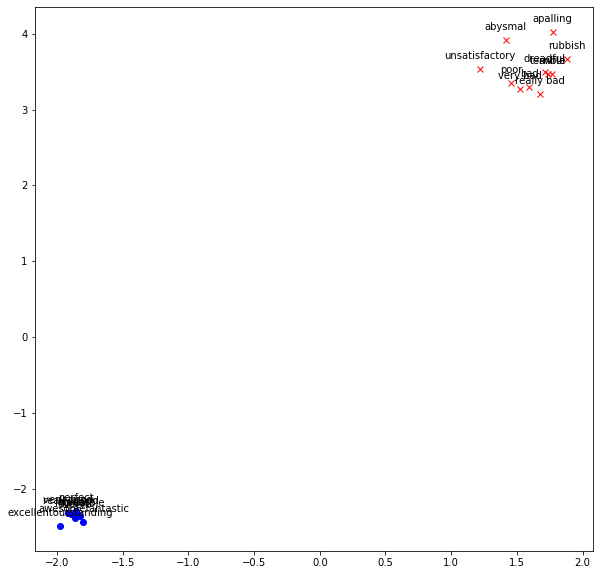

In [9]:
spectrum_activations = spectrum_embeddings_tensors[0][0][:,0,:].numpy()
tsne_spectrum = TSNE(n_components=2, perplexity=10, verbose=1, learning_rate=2,
                     random_state=123).fit_transform(spectrum_activations)

fig = plt.figure(figsize=(10,10))
plt.plot(tsne_spectrum[0:11, 0], tsne_spectrum[0:11, 1], 'rx')
plt.plot(tsne_spectrum[11:, 0], tsne_spectrum[11:, 1], 'bo')
for (x,y, label) in zip(tsne_spectrum[0:, 0], tsne_spectrum[0:, 1], spectrum_df.sentence.values.tolist() ):
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

This new plot show significant clustering of the "good" words in the far lower-left corner, and signficant clustering of the "bad" words in the far upper-right corner. The enhanced model is doing a much better job of identifying and distinguishng "good" and "bad" words.

## Save New Model Version

Use NetApp Snapshot technology to near-instaneously save a new version of the enhanced model so that you will be able to revert back to it in the future if necessary.

In [10]:
modelTag = 'enhanced_' + trainingRunTag
modelDescription = 'Enhanced BERT model.'

bert.config.save_pretrained(MODELS_DIR)
torch.save(bert.state_dict(), MODELS_DIR + 'pytorch_model.bin') # Save pre-trained model to volume

apiResponse, snapshot = netappSnapshotCreate(pvName = modelPvName, snapshotName = modelTag, snapshotComment = modelDescription)

print('API Response: ', apiResponse['state'])
print('Snapshot uuid: ', snapshot['uuid'])
print('Snapshot name: ', snapshot['name'])
print('Snapshot description: ', snapshot['comment'])

API Response:  success
Snapshot uuid:  420e5159-ffe3-11eb-b34c-0050569f4e90
Snapshot name:  enhanced_bert_20210818_044926
Snapshot description:  Enhanced BERT model.


# Explore Saved Models

List all of the model versions that you have saved using NetApp Snapshot technology. If for some reason you weren't happy with the results of the newly-trained model, you can always use the snapshot to quickly revert back to one of the previous model versions.

Note that you could also use NetApp FlexClone technology to clone any one of these saved models in order to experiment with it in a sandboxed workspace. While this capability is not demonstrated in this lab, you can refer to the [NetApp AI Control Plane Technical Report](https://www.netapp.com/us/media/tr-4798.pdf) for more information.

In [11]:
snapshots = netappGetSnapshots(pvName = modelPvName)

# Print list of snapshots
print('Model Tag', '\t\t\t', 'Model Description')
for snapshot in snapshots :
    try:
        print(snapshot['name'], '\t', snapshot['comment'])
    except Exception:
        pass

Model Tag 			 Model Description
baseline_bert_20210818_043740 	 Baseline pre-trained BERT model.
baseline_bert_20210818_044926 	 Baseline pre-trained BERT model.
enhanced_bert_20210818_044926 	 Enhanced BERT model.


The newly enhanced model is clearly more accurate than the baseline model, as demonstrated by the clustering of "good" and "bad" words in the above plot. However, "enhanced" models are not always more accurate than previously-trained models, so assume that this model is actually less accurate than a previous baseline version, and that you want to restore that previous model. To demonstrate this procedure, you will now use NetApp technology to quickly restore the previous baseline model.

Note that restoring a volume to a snapshot destroys any existing snapshots that were taken later on the volume. In this example you are going to restore the volume to the snapshot corresponding to the model's baseline, which will destroy the snapshot of the enhanced model that you just took in the preceding step. If you needed to retain those later snapshots, NetApp FlexClone technology can again help you. While this version of the lab does not include a demonstration of FlexClone, we intend to include it in a future version.

In [12]:
# Restore the Previously Saved Model
modelTag = 'baseline_' + trainingRunTag # Model Tag of the model that we wish to restore
print('Restoring: ', modelTag)

# Restore NetApp snapshot corresponding to model version
result = netappRestoreSnapshot(pvName = modelPvName, snapshotName = modelTag)
print(result)

# Reload model
bert = nemo_nlp.nm.trainables.huggingface.BERT(pretrained_model_name = MODELS_DIR)

Restoring:  baseline_bert_20210818_044926
b'
PLAY [Trigger Snapshot Restore] ************************************************

TASK [Gathering Facts] *********************************************************
ok: [localhost]

TASK [snapshot restore ontap command] ******************************************
changed: [localhost]

PLAY RECAP *********************************************************************
localhost                  : ok=2    changed=1    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   

'


# Re-visualize BERT Embeddings after Restore

Visualize the BERT embeddings once again to confirm that you have reloaded the baseline (non-enhanced) BERT model.

In [13]:
spectrum_words = ['abysmal', 'apalling', 'dreadful', 'awful', 'terrible',
                  'very bad', 'really bad', 'rubbish', 'unsatisfactory',
                  'bad', 'poor', 'great', 'really good', 'very good', 'awesome'
                  'fantastic', 'superb', 'brilliant', 'incredible', 'excellent'
                  'outstanding', 'perfect']

spectrum_file = os.path.join(SPLIT_DATA_DIR, 'positive_negative.tsv')
with open(spectrum_file, 'w+') as f:
    f.write('sentence\tlabel')
    for word in spectrum_words:
        f.write('\n' + word + '\t0')
        
spectrum_df = pd.read_csv(spectrum_file, delimiter='\t')

In [14]:
# Reformat text
spectrum_data = BertTextClassificationDataLayer(input_file=spectrum_file,
                                                tokenizer=tokenizer,
                                                max_seq_length=MAX_SEQ_LEN,
                                                batch_size=BATCH_SIZE)

[NeMo I 2021-08-18 05:15:31 text_classification_dataset:82] data/SST-2/split/positive_negative.tsv: 20
[NeMo I 2021-08-18 05:15:31 data_preprocessing:250] Min: 3 |                  Max: 6 |                  Mean: 3.85 |                  Median: 3.0
[NeMo I 2021-08-18 05:15:31 data_preprocessing:252] 75 percentile: 4.25
[NeMo I 2021-08-18 05:15:31 data_preprocessing:253] 99 percentile: 6.0
[NeMo I 2021-08-18 05:15:31 text_classification_dataset:118] 0 out of 20                         sentences with more than 64 subtokens.
[NeMo I 2021-08-18 05:15:31 text_classification_dataset:175] *** Example ***
[NeMo I 2021-08-18 05:15:31 text_classification_dataset:176] example_index: 0
[NeMo I 2021-08-18 05:15:31 text_classification_dataset:177] subtokens: [CLS] ab ##ys ##mal [SEP]
[NeMo I 2021-08-18 05:15:31 text_classification_dataset:178] sent_label: 0
[NeMo I 2021-08-18 05:15:31 text_classification_dataset:179] input_ids: 101 11113 7274 9067 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [15]:
# Use trained model to create embeddings

spectrum_input, spectrum_token_types, spectrum_attn_mask, spectrum_labels = spectrum_data()

spectrum_embeddings = bert(input_ids=spectrum_input,
                           token_type_ids=spectrum_token_types,
                           attention_mask=spectrum_attn_mask)

spectrum_embeddings_tensors = nf.infer(tensors=[spectrum_embeddings])

[NeMo I 2021-08-18 05:15:32 actions:695] Evaluating batch 0 out of 1


Now that you have reloaded the original model, you should expect the plot to once again show less clustering than you saw in the plot for the enhanced model.

[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 20 samples in 0.000s...
[t-SNE] Computed neighbors for 20 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 20 / 20
[t-SNE] Mean sigma: 2.210003
[t-SNE] KL divergence after 100 iterations with early exaggeration: 35.297852
[t-SNE] KL divergence after 700 iterations: 0.162491


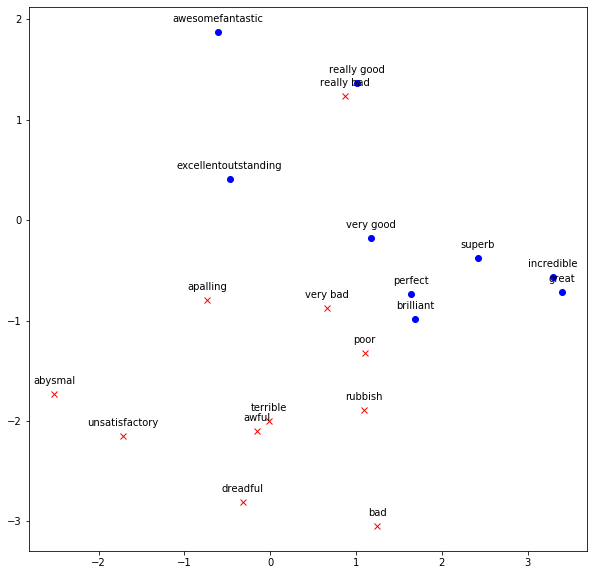

In [16]:
spectrum_activations = spectrum_embeddings_tensors[0][0][:,0,:].numpy()
tsne_spectrum = TSNE(n_components=2, perplexity=10, verbose=1, learning_rate=2,
                     random_state=123).fit_transform(spectrum_activations)

fig = plt.figure(figsize=(10,10))
plt.plot(tsne_spectrum[0:11, 0], tsne_spectrum[0:11, 1], 'rx')
plt.plot(tsne_spectrum[11:, 0], tsne_spectrum[11:, 1], 'bo')
for (x,y, label) in zip(tsne_spectrum[0:, 0], tsne_spectrum[0:, 1], spectrum_df.sentence.values.tolist() ):
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

The words are no longer clustered in this plot.